In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

# Assume the following transformation classes are defined in a 'transform.py' file.
# If they are in a different file, you will need to adjust the import statement.
from transform import VideoRotate, VideoDiffeo, SubsampleTime, MonophasicTimeWarp, TemporalNoise, TimeReverse

torch.Size([1, 1, 20, 64, 64])


In [7]:
def load_dynamic_img(N_time, patient_id, slice_idx=41):

        H = W = 320
        data = np.empty((2, N_time, H, W), dtype=np.float32)

        for t in range(N_time):
            # load image 
            img_path = f'/ess/scratch/scratch1/rachelgordon/dce-{N_time}tf/{patient_id}/slice_{slice_idx:03d}_frame_{t:03d}.nii'

            # if os.path.exists(img_path):

            img = nib.load(img_path)
            img_data = img.get_fdata()

            if img_data.shape != (2, H, W):
                raise ValueError(f"{img_path} has shape {img_data.shape}; "
                                f"expected (2, {H}, {W})")

            data[:, t] = img_data.astype(np.float32)
            
            # else:
            #     return None

        return torch.from_numpy(data) 

In [11]:
mri_time_series = load_dynamic_img(N_time=8, patient_id="fastMRI_breast_001_2")

mri_time_series = torch.abs(mri_time_series[0] + 1j * mri_time_series[1]).unsqueeze(0).unsqueeze(0)
print(mri_time_series.shape)

torch.Size([1, 1, 8, 320, 320])


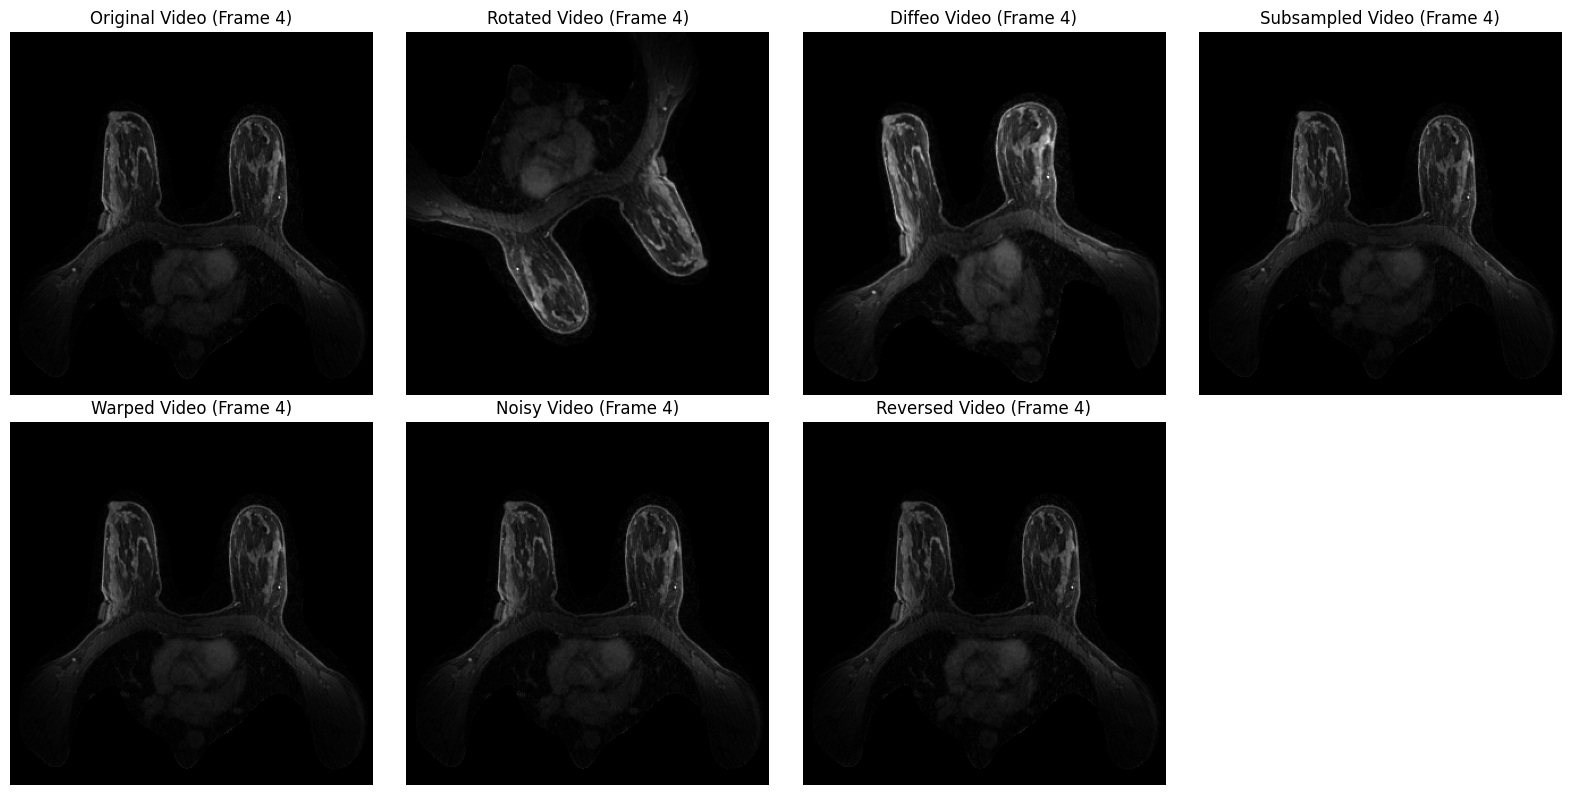

In [13]:
# Define the transformations
# You can adjust the parameters of each transformation as needed.
video_rotate = VideoRotate(n_trans=1, interpolation_mode="bilinear")
video_diffeo = VideoDiffeo(n_trans=1, device='cpu')
subsample_time = SubsampleTime(n_trans=1, subsample_ratio_range=(0.5, 0.5))
monophasic_time_warp = MonophasicTimeWarp(n_trans=1, warp_ratio_range=(1.5, 1.5))
temporal_noise = TemporalNoise(n_trans=1)
time_reverse = TimeReverse(n_trans=1)

# Apply the transformations
rotated_video = video_rotate(mri_time_series)
diffeo_video = video_diffeo(mri_time_series)
subsampled_video = subsample_time(mri_time_series)
warped_video = monophasic_time_warp(mri_time_series)
noisy_video = temporal_noise(mri_time_series)
reversed_video = time_reverse(mri_time_series)

# Plot the results
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# Plot the original video
axes[0].imshow(mri_time_series[0, 0, 4, :, :], cmap='gray')
axes[0].set_title("Original Video (Frame 4)")
axes[0].axis('off')

# Plot the rotated video
axes[1].imshow(rotated_video[0, 0, 4, :, :], cmap='gray')
axes[1].set_title("Rotated Video (Frame 4)")
axes[1].axis('off')

# Plot the diffeo video
axes[2].imshow(diffeo_video[0, 0, 4, :, :], cmap='gray')
axes[2].set_title("Diffeo Video (Frame 4)")
axes[2].axis('off')

# Plot the subsampled video
axes[3].imshow(subsampled_video[0, 0, 4, :, :], cmap='gray')
axes[3].set_title("Subsampled Video (Frame 4)")
axes[3].axis('off')

# Plot the warped video
axes[4].imshow(warped_video[0, 0, 4, :, :], cmap='gray')
axes[4].set_title("Warped Video (Frame 4)")
axes[4].axis('off')

# Plot the noisy video
axes[5].imshow(noisy_video[0, 0, 4, :, :], cmap='gray')
axes[5].set_title("Noisy Video (Frame 4)")
axes[5].axis('off')

# Plot the reversed video
axes[6].imshow(reversed_video[0, 0, 4, :, :], cmap='gray')
axes[6].set_title("Reversed Video (Frame 4)")
axes[6].axis('off')

# Hide the last subplot
axes[7].axis('off')

plt.tight_layout()
plt.show()